In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

import os
os.chdir('../methods')
import lsci, supr, conf, uqno, prob_don, quant_don, gaus
os.chdir('../gpsims')

os.chdir('../models_and_metrics')
from models import *
from metrics import * 
from utility import *
os.chdir('../gpsims')

import neuralop as op
from neuralop.models import FNO, LocalFNO, UNO, TFNO
import jaxwt as jwt
import pcax
from jax.scipy.stats import norm, laplace

In [2]:
import pandas as pd
air = pd.read_csv('../data/PRSA_Data_Tiantan_20130301-20170228.csv')
air["date"] = air["year"].astype(str) + '_' + air["month"].astype(str) + '_' + air["day"].astype(str)

In [3]:
air_curves = np.array(air.groupby('date')['PM2.5'].apply(list).reset_index())
dts = air_curves[:,0]
fns = air_curves[:,1]

# transform
fns = [np.array(f) for f in fns]
fns = [jax.image.resize(f, 24, 'bicubic') for f in fns]
fns = np.array(fns)

# backfill missing
missing = jnp.sum(jnp.isnan(fns), axis = 1) > 0
for i in range(fns.shape[0]):
    if missing[i]:
        fns[i] = fns[i-1]

y = fns
# y = np.log(y[:,None,:,None])

x = []
variables = ['TEMP', 'PRES', 'DEWP']
for k in trange(len(variables)):
    air_curves = np.array(air.groupby('date')[variables[k]].apply(list).reset_index())
    dts = air_curves[:,0]
    fns = air_curves[:,1]
    
    # transform
    fns = [np.array(f) for f in fns]
    fns = [jax.image.resize(f, 24, 'bicubic') for f in fns]
    fns = np.array(fns)
    
    # backfill missing
    missing = jnp.sum(jnp.isnan(fns), axis = 1) > 0
    for i in range(fns.shape[0]):
        if missing[i]:
            fns[i] = fns[i-1]

    x.append(fns)
    
x = np.array(x)
x = np.moveaxis(x, 0, 2)[:,None]

x_mu = np.mean(x, axis = (0,2))[None,:,None]
x_sd = np.std(x, axis = (0,2))[None,:,None]
x = (x - x_mu)/x_sd

y = y / jnp.max(y)

  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# plt.plot(y[0:10].T)
# plt.show()

In [5]:
ntrain, nval = 600, 1200

xtrain = x[:ntrain].reshape(-1, 3, 24)
ytrain = y[:ntrain].reshape(-1, 1, 24)

xval = x[ntrain:nval].reshape(-1, 3, 24)
yval = y[ntrain:nval].reshape(-1, 1, 24)

xtest = x[nval:].reshape(-1, 3, 24)
ytest = y[nval:].reshape(-1, 1, 24)

train_data = TensorDataset(torch.Tensor(np.array(xtrain)), torch.Tensor(np.array(ytrain)))
train_loader = DataLoader(train_data, batch_size = 30, shuffle = True)

In [6]:
loss_fn = nn.MSELoss()

fno = FNO(n_modes=(16,), 
             hidden_channels=64, 
             in_channels=3, 
             out_channels=1)
optim_fno = torch.optim.Adam(fno.parameters(), lr = 1e-3)

epochs = 20
for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):  
        yhat = fno(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()
        
with torch.no_grad():
    yval_fno = torch2jax(fno(jax2torch(xval)).squeeze())

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
with torch.no_grad():
    yval_fno = fno(jax2torch(xval).to(device)).cpu().squeeze()
    yval_fno = torch2jax(yval_fno)

In [8]:
with torch.no_grad():
    ytest_fno = fno(jax2torch(xtest).to(device)).cpu().squeeze()
    ytest_fno = torch2jax(ytest_fno)

In [9]:
rval_fno = yval.squeeze() - yval_fno
rtest_fno = ytest.squeeze() - ytest_fno

In [10]:
nproj = 100
n_samp = 2000
n_phi = 20
alpha = 0.1
ncal = nval - ntrain
adj_alpha = jnp.ceil((ncal+1)*(1-alpha))/ncal

In [34]:
#### cross validation lambda selection
n_samp = 2000
n_phi = 20
alpha = 0.1

rng = random.key(0)
idx = random.bernoulli(rng, 0.5, ncal)

xcal1 = xval[idx]
xcal2 = xval[~idx]

ycal1 = yval[idx]
ycal2 = yval[~idx]

rcal1 = rval_fno[idx]
rcal2 = rval_fno[~idx]

ncal1 = xcal1.shape[0]
ncal2 = xcal2.shape[0]
adj_alpha = jnp.ceil((ncal1+1)*(1-alpha))/ncal1

xstate = lsci.weighted_fpca(xcal1.reshape(ncal1, -1), 
                            jnp.ones(ncal1)/ncal1)

xstate[-1] = xstate[-1][:,0:25]
xcal1_fpc = lsci.transform_fpca(xcal1.reshape(ncal1, -1),  
                               xstate)
xcal2_fpc = lsci.transform_fpca(xcal2.reshape(ncal2, -1), 
                                xstate)

lam_search = [1, 2, 3, 4, 5, 7, 9, 11]
n_lam = len(lam_search)
cover = np.zeros((ncal2, n_lam))
width = np.zeros((ncal2, n_lam))

for i, lam in tqdm(enumerate(lam_search)):
    l2_weights = lsci.linf_localizer(xcal1_fpc.squeeze(), 
                                   xcal2_fpc.squeeze() + 0.1*random.normal(rng, xcal2_fpc.squeeze().shape), 
                                   lam)
    for k in trange(ncal2):
    
        rng, key1, key2, key3 = random.split(rng, 4)
        ## LSCI 
        weight_k = l2_weights[k:(k+1)]
        rng, sample_rng, reject_rng = random.split(rng, 3)
        lsci_ens = lsci.fpca_sampler(rcal1, weight_k, n_samp, sample_rng)
        lsci_ens = lsci.depth_reject(rcal1, lsci_ens, weight_k, n_phi, adj_alpha, reject_rng)
        lsci_lower = jnp.min(lsci_ens, axis = 0)
        lsci_upper = jnp.max(lsci_ens, axis = 0)
        
        cover[k, i] = risk(lsci_lower, lsci_upper, rcal2[k])
        width[k, i] =  jnp.median(lsci_upper - lsci_lower)

0it [00:00, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

ValueError: zero-size array to reduction operation min which has no identity

In [35]:
lam_search, np.mean(cover > 0.99, axis = 0), np.mean(width, axis = 0)

([1, 2, 3, 4, 5, 7, 9, 11],
 array([0.91373802, 0.88178914, 0.84345048, 0.79872204, 0.71565495,
        0.58146965, 0.14696486, 0.        ]),
 array([0.46394878, 0.41978198, 0.3788242 , 0.34106193, 0.31077452,
        0.26601102, 0.08874787, 0.        ]))

In [ ]:
ntest = ytest.shape[0]
nmod = 4 + 6
cover = np.zeros((ntest, nmod))
width = np.zeros((ntest, nmod))

rng = random.key(1)
xstate = lsci.weighted_fpca(xval.reshape(ncal, -1), 
                            jnp.ones(xval.shape[0])/xval.shape[0])

xstate[-1] = xstate[-1][:,0:25]
xval_fpc = lsci.transform_fpca(xval.reshape(ncal, -1),  
                               xstate)
xtest_fpc = lsci.transform_fpca(xtest.reshape(ntest, -1), 
                                xstate)

l2_weights = lsci.l2_localizer(xval_fpc.squeeze(), 
                               xtest_fpc.squeeze() + 0.1*random.normal(rng, xtest_fpc.squeeze().shape), 
                               10)

for k in trange(0, ntest):
    
    rng, key1, key2, key3 = random.split(rng, 4)

    ## LSCI 
    weight_k = l2_weights[k:(k+1)]
    rng, sample_rng, reject_rng = random.split(rng, 3)
    lsci_ens = lsci.fpca_sampler(rval_fno, weight_k, n_samp, sample_rng)
    lsci_ens = lsci.depth_reject(rval_fno, lsci_ens, weight_k, n_phi, adj_alpha, reject_rng)
    lsci_lower = jnp.min(lsci_ens, axis = 0)
    lsci_upper = jnp.max(lsci_ens, axis = 0)
    
    cover[k, 0] = risk(lsci_lower, lsci_upper, rtest_fno[k])
    width[k, 0] =  jnp.median(lsci_upper - lsci_lower)

In [31]:
sigma = jnp.sqrt(jnp.mean(rtest_fno**2, axis = 1))

In [32]:
dcorr(width[:ntest,0], sigma[:ntest]), dcorr(cover[:ntest,0], sigma[:ntest])

(Array(0.21216854, dtype=float32), Array(0.24166895, dtype=float32))

(np.float64(0.9386973180076629), np.float64(0.39800859633761804))

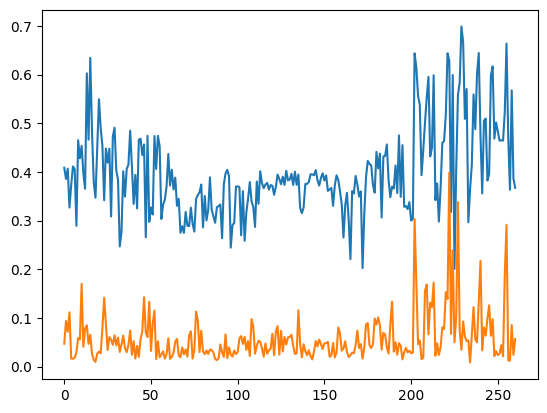

In [33]:
plt.plot(width[:,0])
plt.plot(sigma)

np.mean(cover[:ntest,0] > 0.99), np.mean(width[:ntest,0])

In [56]:
# metrics
sigma = jnp.sqrt(jnp.mean(rtest_fno**2, axis =1))
# sigma = sd[1:,0]

cover_mean = np.round(np.mean(cover >= 0.99, axis = 0), 3)
width_mean = np.round(np.mean(width, axis = 0), 3)

## correlations
cover_dcor = np.zeros(nmod)
width_dcor = np.zeros(nmod)
for i in range(nmod):
    cover_dcor[i] = dcorr(cover[:,i], sigma)
    width_dcor[i] = dcorr(width[:,i], sigma)

metrics_mean = np.vstack([
    cover_mean,
    cover_dcor,
    width_mean,
    width_dcor
]).T

In [57]:
np.set_printoptions(suppress=True)
print(np.round(np.nan_to_num(metrics_mean[4:], 0), 3))

[[0.973 0.337 0.553 0.   ]
 [0.969 0.336 0.571 0.   ]
 [0.95  0.407 0.699 0.   ]
 [0.985 0.254 0.66  0.079]
 [0.621 0.329 0.226 0.261]
 [0.943 0.271 0.463 0.076]]


In [58]:
print(np.round(np.nan_to_num(metrics_mean[0:4], 0), 3))

[[0.958 0.237 0.445 0.209]
 [0.92  0.211 0.387 0.212]
 [0.954 0.271 0.444 0.215]
 [0.897 0.294 0.385 0.201]]


In [119]:
epochs = 50
lag, lead = len(variables), 1

width = 50
drop_prob = 0.1

rng = random.PRNGKey(0)
model_rng = nnx.Rngs(1)
base_model = DeepANO(lag, width, lead, rngs=model_rng)
prob_model = ProbANO(lag, width, lead, rngs=model_rng)
quant_model = DeepANO(lag, width, lead, rngs=model_rng)

base_optim = nnx.Optimizer(base_model, optax.adam(1e-3))
prob_optim = nnx.Optimizer(prob_model, optax.adam(1e-3))
quant_optim = nnx.Optimizer(quant_model, optax.adam(1e-3))

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        base_loss = train_step(base_model, base_optim, xt, yt)
        prob_loss = prob_step(prob_model, prob_optim, xt, yt)
        quant_loss = quant_step(quant_model, quant_optim, xt, yt)

  0%|          | 0/50 [00:00<?, ?it/s]

In [120]:
yval_hat = base_model(xval)
ytest_hat = base_model(xtest)

yval_quant = quant_model(xval)
ytest_quant = quant_model(xtest)

yval_mu, yval_sd = prob_model(xval)
ytest_mu, ytest_sd = prob_model(xtest)

In [121]:
yval = yval.squeeze()
ytest = ytest.squeeze()

yval_hat = yval_hat.squeeze()
ytest_hat = ytest_hat.squeeze()
yval_quant = yval_quant.squeeze()
ytest_quant = ytest_quant.squeeze()
yval_mu = yval_mu.squeeze()
yval_sd = yval_sd.squeeze()
ytest_mu = ytest_mu.squeeze()
ytest_sd = ytest_sd.squeeze()

In [122]:
nproj = npc = 24
gamma1 = 0.1
gamma2 = 0.05
alpha = 0.1
nval = xval.shape[0]

drop_risk, drop_width = [], []
orcl_risk, orcl_width = [], []
conf_risk, conf_width = [], []
gaus_risk, gaus_width = [], []
supr_risk, supr_width = [], []
uqn1_risk, uqn1_width = [], []
pdon_risk, pdon_width = [], []
qdon_risk, qdon_width = [], []
lsc1_risk, lsc1_width = [], []
lsc2_risk, lsc2_width = [], []

rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()
rtest2 = (ytest - ytest_mu).squeeze()

state = lsci.lsci_state(xval, rval, npc, localization='l2')
pca_state = state[-1]

quant_scores = jnp.abs(yval - yval_hat) / yval_quant
lam_uqno = uqno.estimate_lambda(quant_scores, 0.1, 0.01, 1.1)

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
gaus_lower, gaus_upper = gaus.gaus_band(rval, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval, alpha)
uqn1_lower, uqn1_upper = uqno.uqno_band(ytest_quant, lam_uqno)
pdon_lower, pdon_upper = prob_don.prob_don(prob_model, xval, xtest, yval, alpha)
qdon_lower, qdon_upper = quant_don.quant_don(quant_model, xval, xtest, yval - yval_hat, alpha)

for i in trange(0, ytest.shape[0]):
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, 2000, gamma1)
    lsc1_risk.append(risk(lsc1_lower, lsc1_upper, rtest[i]))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))
    
    # LSCI
    lsc2_lower, lsc2_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, 2000, gamma2)
    lsc2_risk.append(risk(lsc2_lower, lsc2_upper, rtest[i]))
    lsc2_width.append(jnp.median(lsc2_upper - lsc2_lower))

    # Oracle
    orcl_lower = -(jnp.abs(rtest[i]) + 1e-4)
    orcl_upper = jnp.abs(rtest[i]) + 1e-4
    orcl_risk.append(risk(orcl_lower, orcl_upper, rtest[i]))
    orcl_width.append(jnp.median(orcl_upper - orcl_lower))
    
    # CONF 
    conf_risk.append(risk(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.median(conf_upper - conf_lower))
    
    # GAUSS 
    gaus_risk.append(risk(gaus_lower, gaus_upper, rtest[i]))
    gaus_width.append(jnp.median(gaus_upper - gaus_lower))
    
    # SUPR
    supr_risk.append(risk(supr_lower, supr_upper, rtest[i]))
    supr_width.append(jnp.median(supr_upper - supr_lower))
    
    # UQNO
    uqn1_risk.append(risk(uqn1_lower[i], uqn1_upper[i], rtest[i]))
    uqn1_width.append(jnp.median(uqn1_upper[i] - uqn1_lower[i]))
    
    # PDON
    pdon_risk.append(risk(pdon_lower[i], pdon_upper[i], rtest2[i]))
    pdon_width.append(jnp.median(pdon_upper[i] - pdon_lower[i]))
    
    # PDON
    qdon_risk.append(risk(qdon_lower[i], qdon_upper[i], rtest[i]))
    qdon_width.append(jnp.median(qdon_upper[i] - qdon_lower[i]))
    
    # # DROPOUT
    # drop_model.train()
    # drop_set = jnp.stack([drop_model(xtest[i:(i+1)]).squeeze() for _ in range(500)])
    # drop_lower = jnp.quantile(drop_set, alpha/2, axis = 0)
    # drop_upper = jnp.quantile(drop_set, 1 - alpha/2, axis = 0)
    # drop_model.eval()
    
    # drop_risk.append(risk(drop_lower, drop_upper, rtest[i]))
    # drop_width.append(jnp.median(drop_upper - drop_lower))

orcl_risk, orcl_width = np.array(orcl_risk), np.array(orcl_width)
drop_risk, drop_width = np.array(drop_risk), np.array(drop_width)
conf_risk, conf_width = np.array(conf_risk), np.array(conf_width)
gaus_risk, gaus_width = np.array(gaus_risk), np.array(gaus_width)
supr_risk, supr_width = np.array(supr_risk), np.array(supr_width)
uqn1_risk, uqn1_width = np.array(uqn1_risk), np.array(uqn1_width)
lsc1_risk, lsc1_width = np.array(lsc1_risk), np.array(lsc1_width)
lsc2_risk, lsc2_width = np.array(lsc2_risk), np.array(lsc2_width)
pdon_risk, pdon_width = np.array(pdon_risk), np.array(pdon_width)
qdon_risk, qdon_width = np.array(qdon_risk), np.array(qdon_width)

  0%|          | 0/261 [00:00<?, ?it/s]

In [123]:
drop_risk, drop_width = jnp.zeros(ytest.shape[0]),  jnp.zeros(ytest.shape[0])

In [124]:
noise_sd = jnp.mean(rtest**2, axis = 1)

In [125]:
gamma = 0.99

risk_control = np.mean(orcl_risk >= gamma), \
               np.mean(drop_risk >= gamma), \
               np.mean(conf_risk >= gamma), \
               np.mean(gaus_risk >= gamma), \
               np.mean(supr_risk >= gamma), \
               np.mean(uqn1_risk >= gamma), \
               np.mean(pdon_risk >= gamma), \
               np.mean(qdon_risk >= gamma), \
               np.mean(lsc1_risk >= gamma), \
               np.mean(lsc2_risk >= gamma)

width = np.mean(orcl_width), \
        np.mean(drop_width), \
        np.mean(conf_width), \
        np.mean(gaus_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(pdon_width), \
        np.mean(qdon_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = -0, \
           np.corrcoef([noise_sd, drop_risk])[0,1], \
           np.corrcoef([noise_sd, conf_risk])[0,1], \
           np.corrcoef([noise_sd, gaus_risk])[0,1], \
           np.corrcoef([noise_sd, supr_risk])[0,1], \
           np.corrcoef([noise_sd, uqn1_risk])[0,1], \
           np.corrcoef([noise_sd, pdon_risk])[0,1], \
           np.corrcoef([noise_sd, qdon_risk])[0,1], \
           np.corrcoef([noise_sd, lsc1_risk])[0,1], \
           np.corrcoef([noise_sd, lsc2_risk])[0,1]

width_cor = 1, \
            np.corrcoef([noise_sd, drop_width])[0,1], \
            0, \
            0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, pdon_width])[0,1], \
            np.corrcoef([noise_sd, qdon_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

/home/tharris/climate/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tharris/climate/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [126]:
methods = ['Oracle', 'MC-Drop', 'Conf1', 'Conf2', 
           'Supr', 'CQR-NO', 'Prob-NO', 'Quant-NO', 
           'LSCI1', 'LSCI2']

for i in range(metrics.shape[0]):
    print(f'{methods[i]} & ', end = '')
    for j in range(metrics.shape[1]):
        val = f'{np.round(np.nan_to_num(metrics[i,j]), 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

Oracle & 1.000 & 0.000 & 87.938 & 1.000 \\
MC-Drop & 0.000 & 0.000 & 0.000 & 0.000 \\
Conf1 & 0.969 & -0.867 & 453.874 & 0.000 \\
Conf2 & 0.958 & -0.872 & 448.337 & 0.000 \\
Supr & 0.946 & -0.805 & 449.777 & 0.000 \\
CQR-NO & 0.985 & -0.114 & 1309.577 & 0.459 \\
Prob-NO & 0.874 & -0.672 & 313.344 & -0.032 \\
Quant-NO & 0.678 & -0.061 & 222.917 & 0.460 \\
LSCI1 & 0.981 & -0.667 & 365.285 & 0.390 \\
LSCI2 & 0.946 & -0.523 & 330.759 & 0.439 \\
